### Import Libraries


In [5]:
import pandas as pd
import pathlib
from joblib import load
from matplotlib import pyplot as plt

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import class_PR_curves

### Load models and datasets


In [6]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

train_data = get_dataset(features_dataframe, data_split_indexes, "train")
test_data = get_dataset(features_dataframe, data_split_indexes, "test")

save_dir = pathlib.Path("evaluations/class_precision_recall_curves/")
save_dir.mkdir(parents=True, exist_ok=True)


### Evaluate Each Model on Each Dataset


Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: train


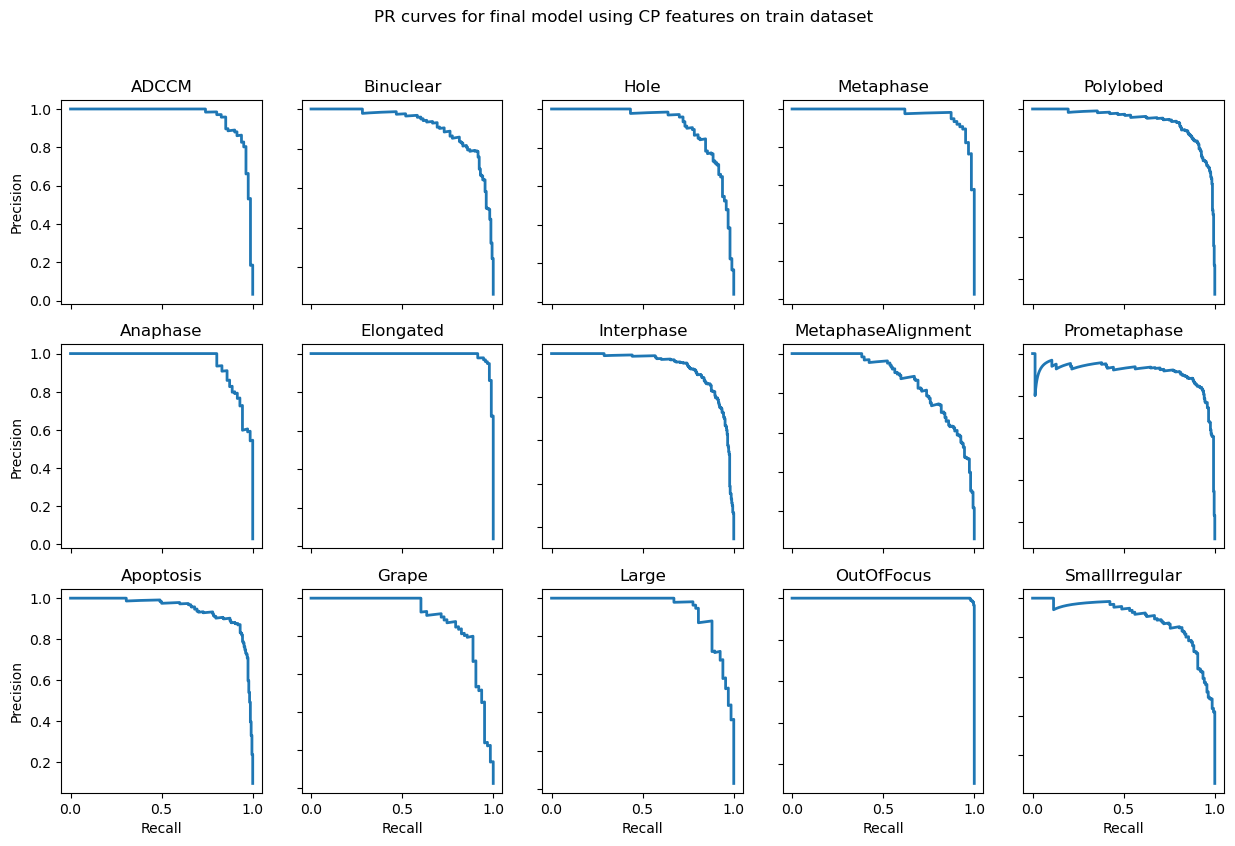

Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: test


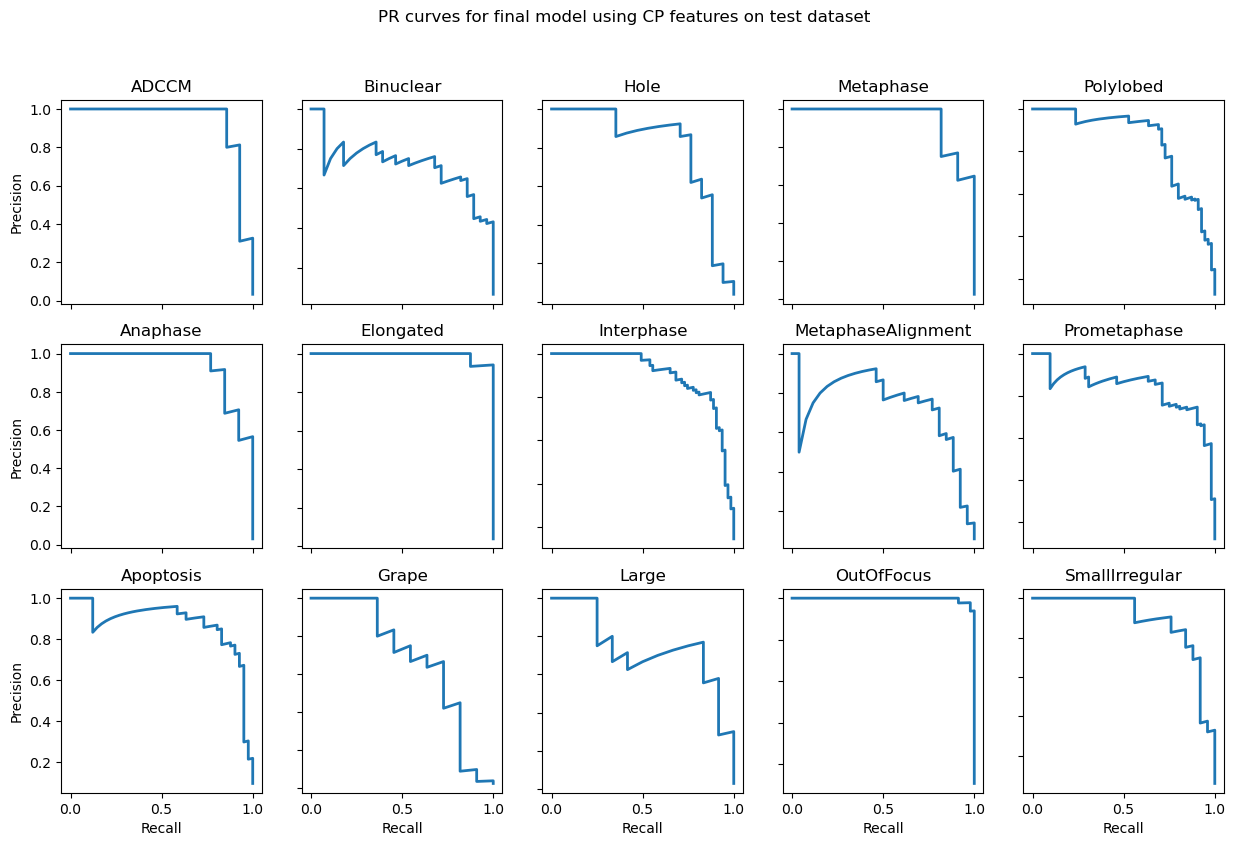

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: train


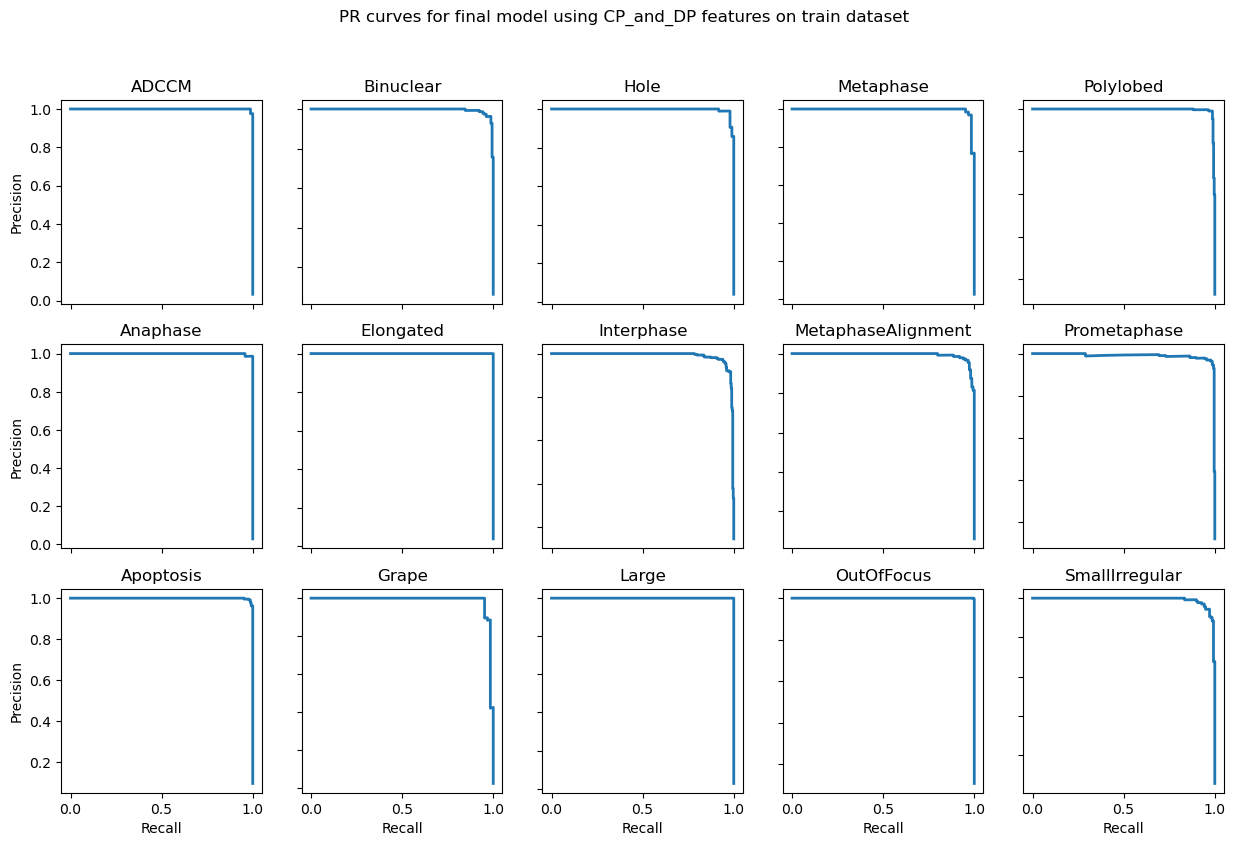

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: test


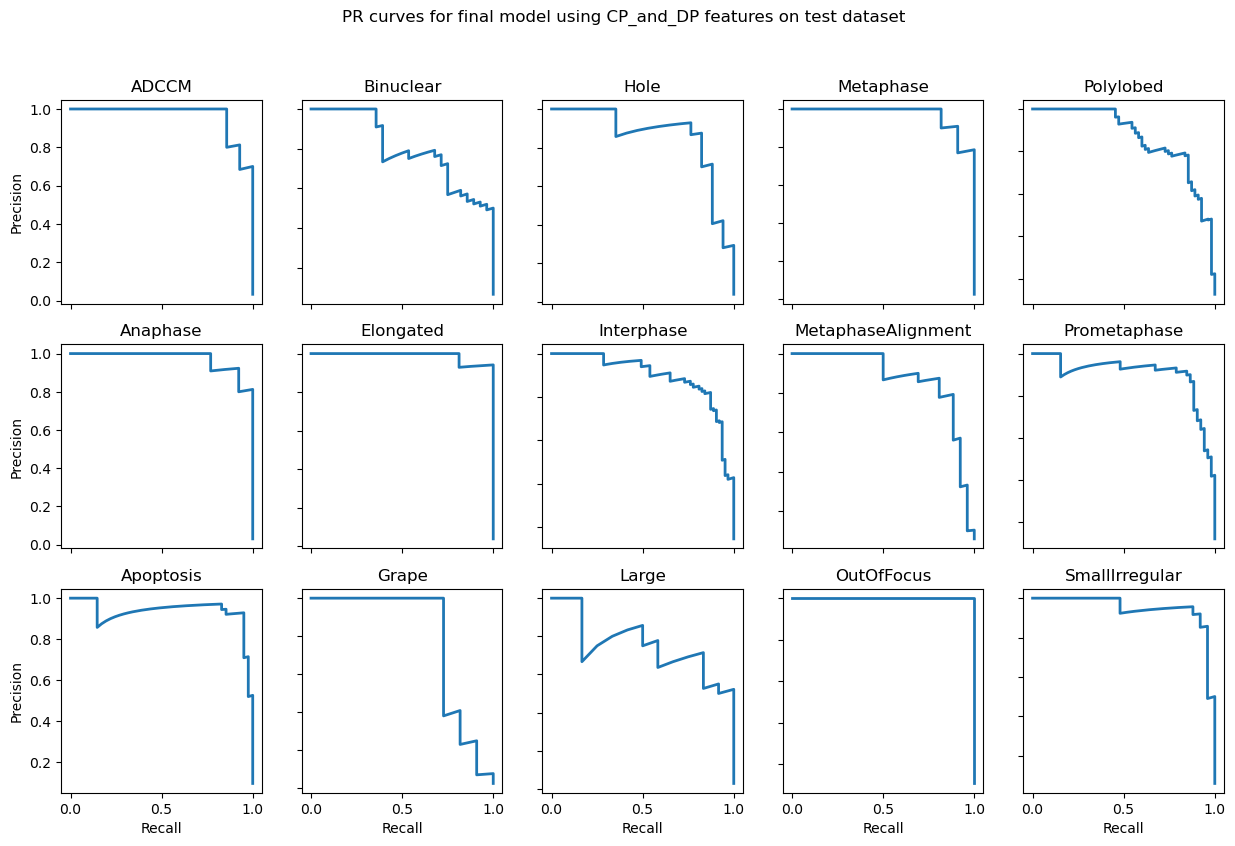

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: train


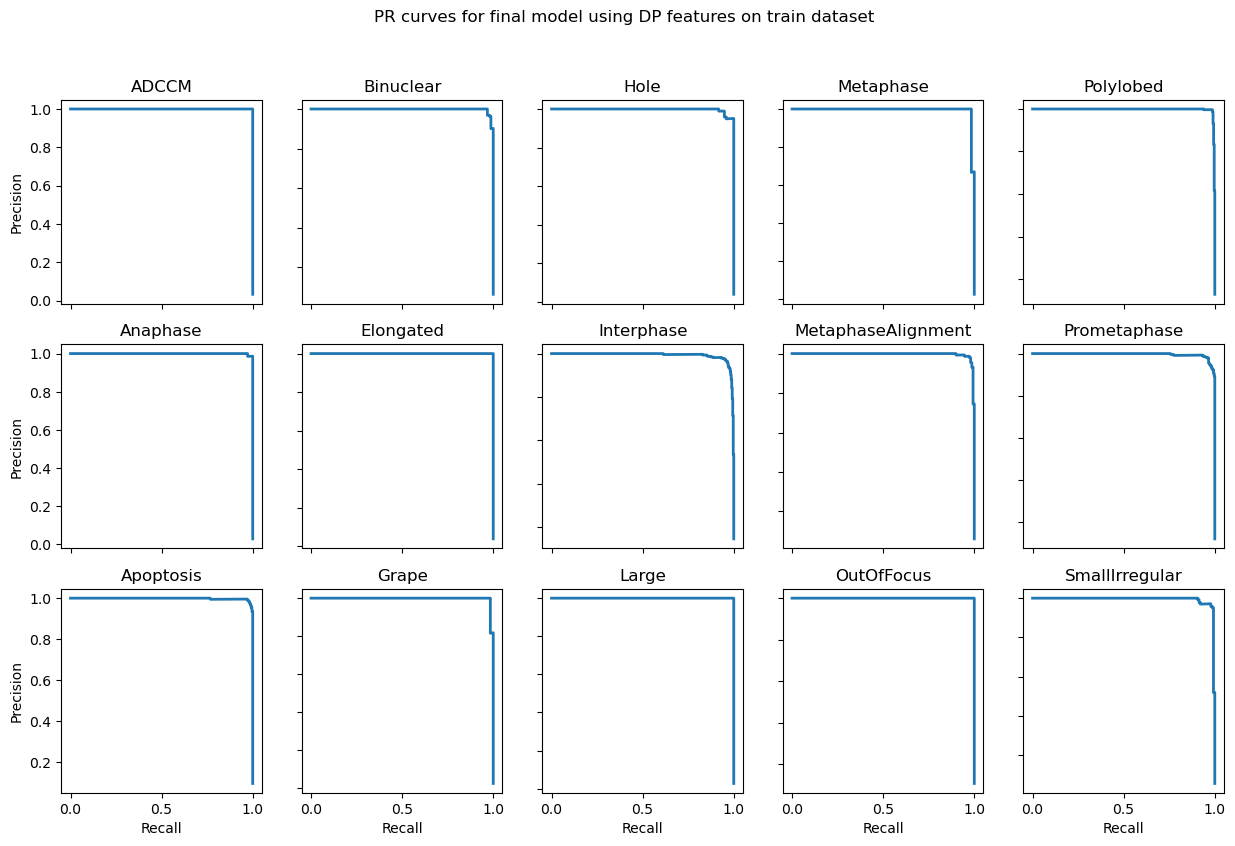

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: test


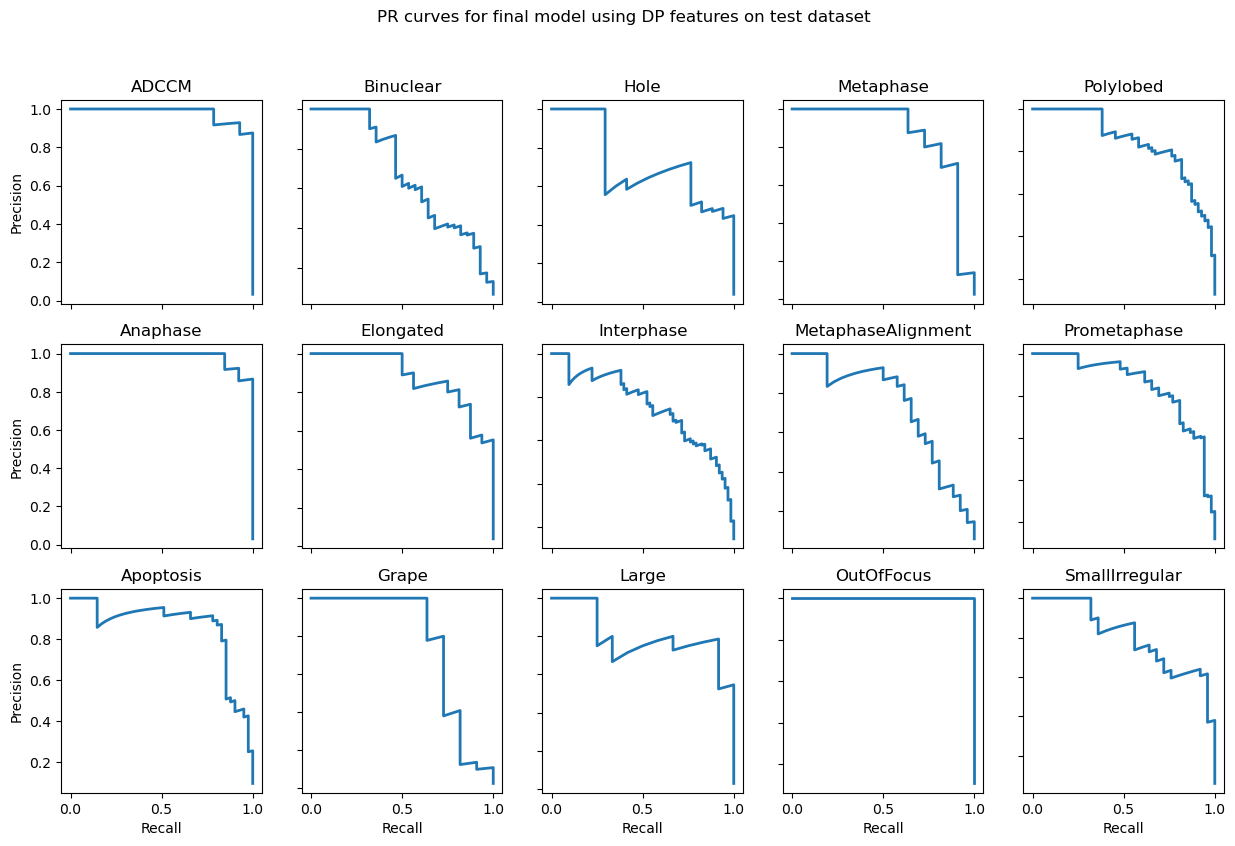

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: train


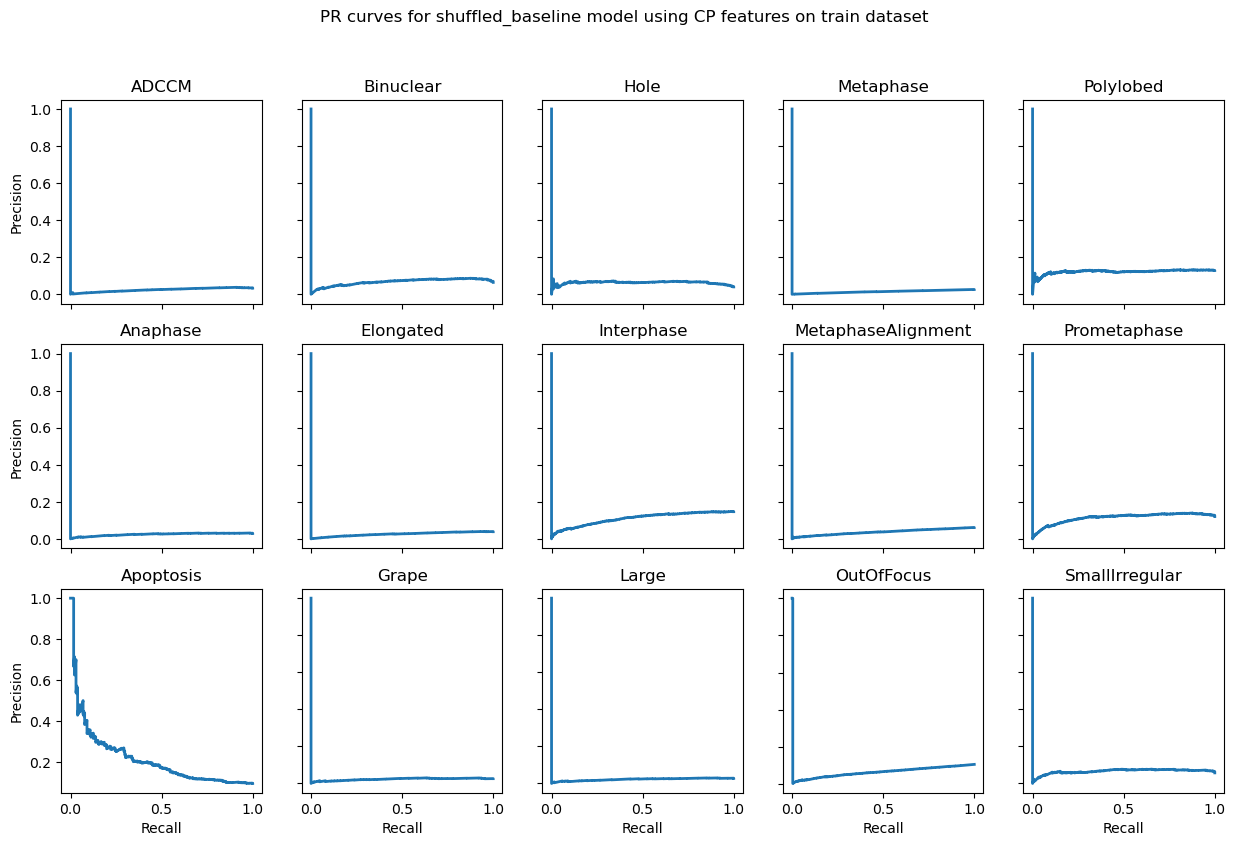

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: test


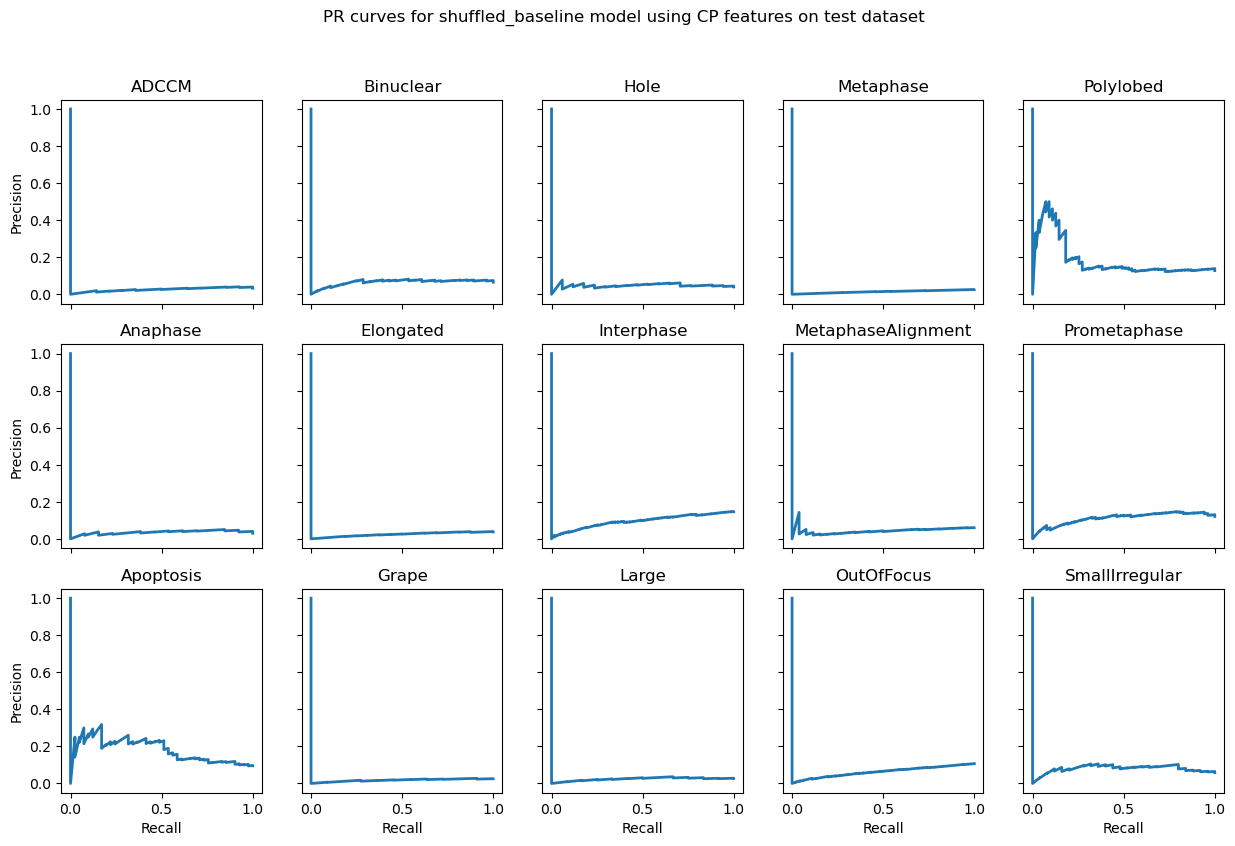

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: train


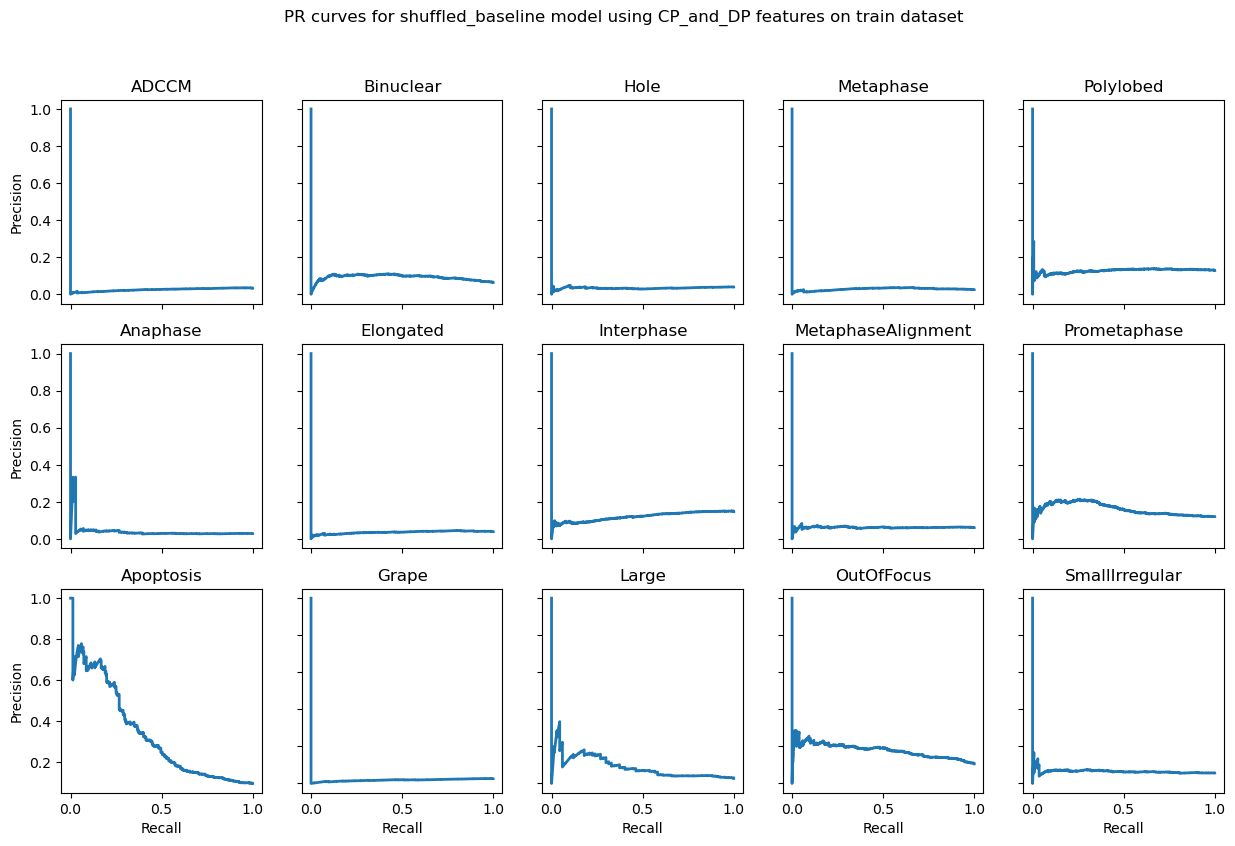

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: test


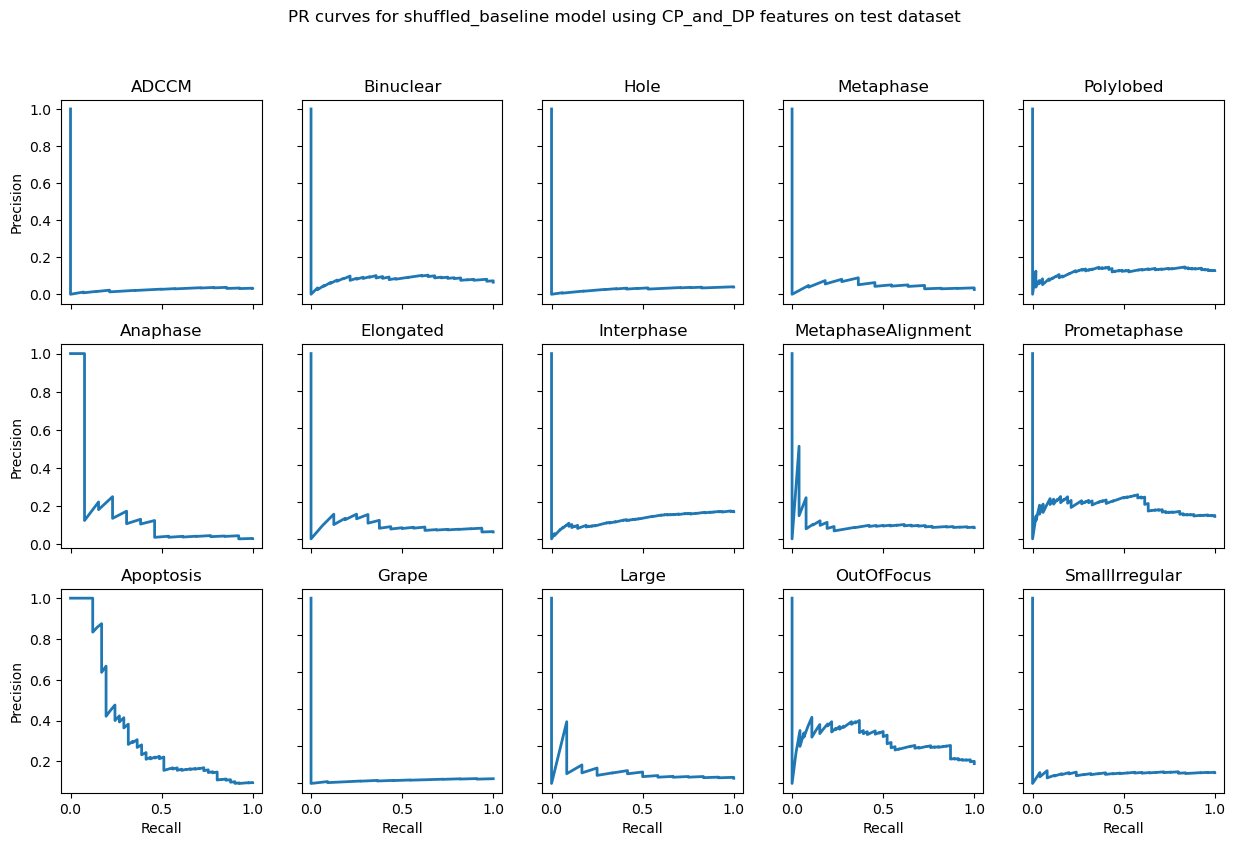

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: train


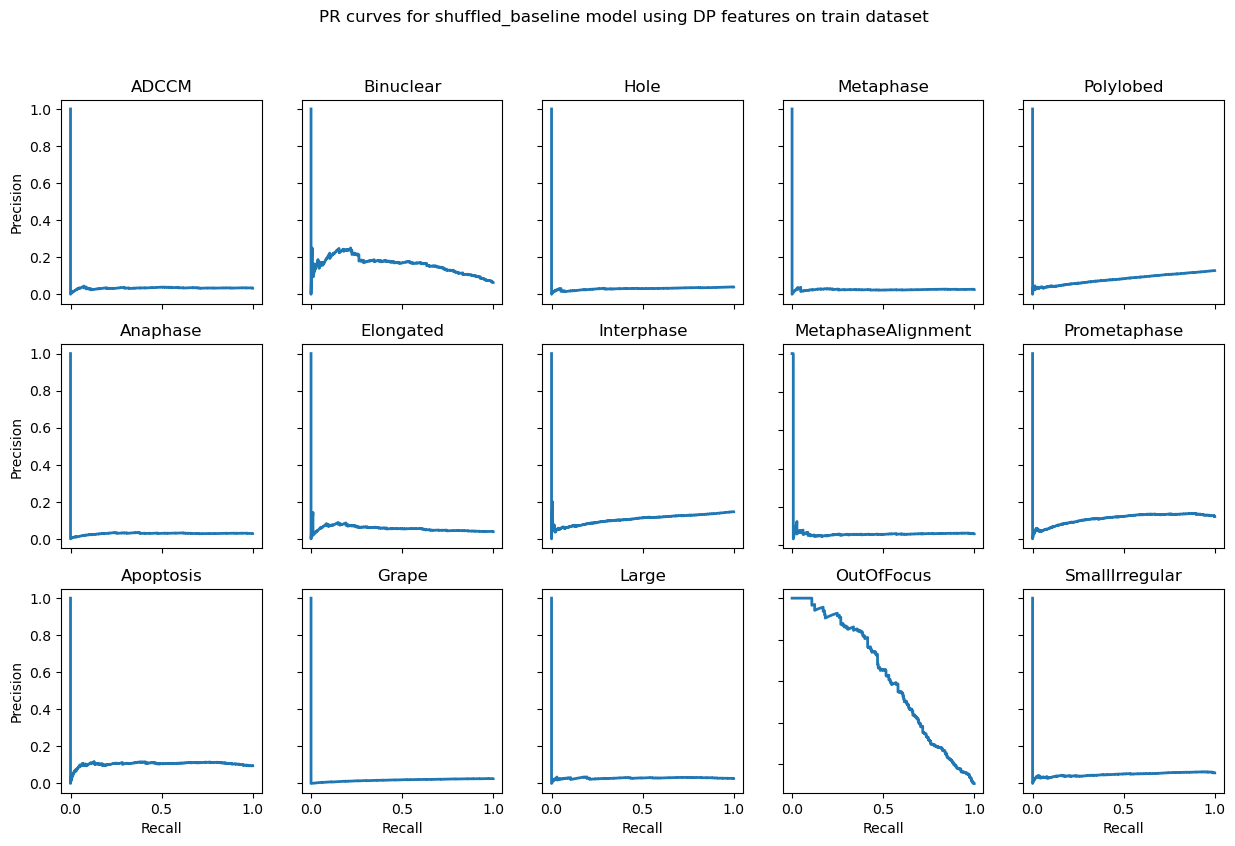

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: test


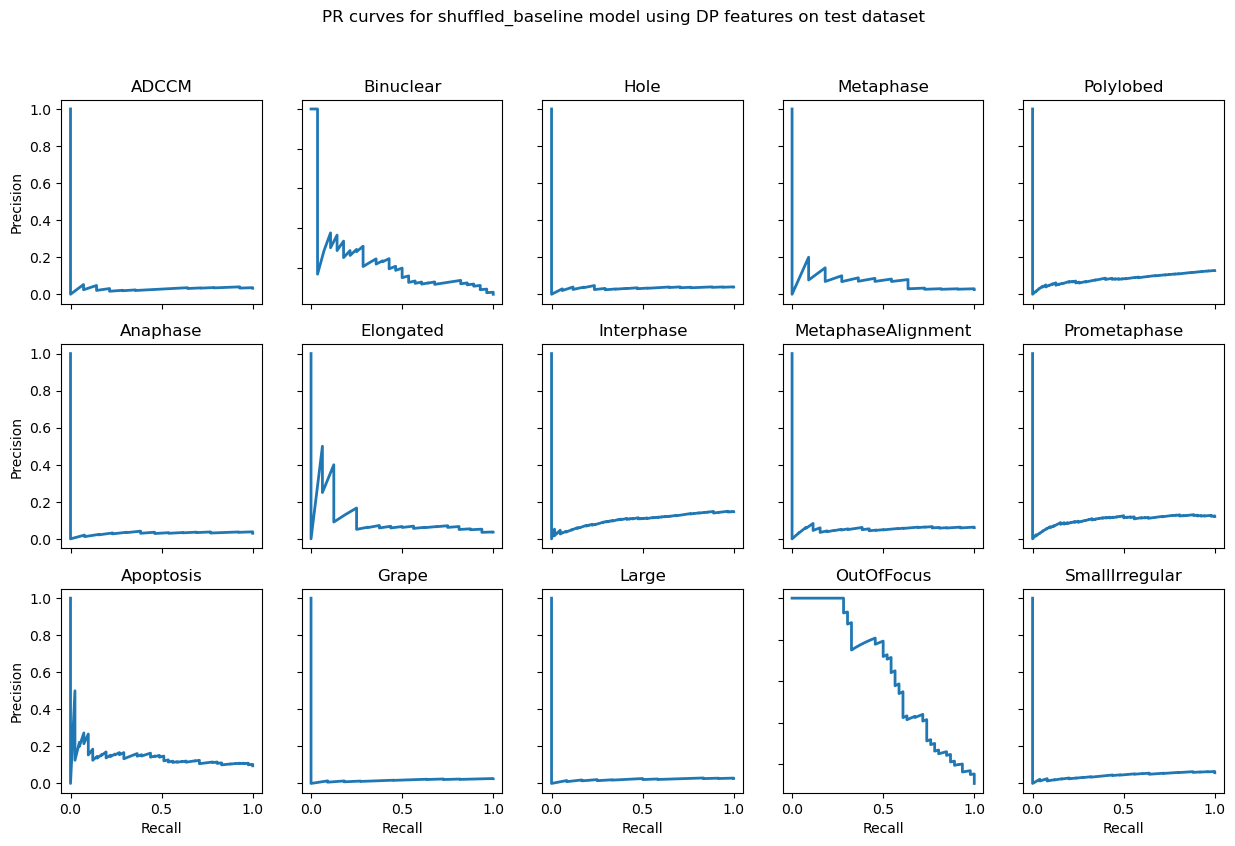

In [7]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_class_PR_curves = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    # load model
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {label}"
        )

        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)

        # get class PR curve data and show curve
        fig, PR_data = class_PR_curves(data, model, feature_type)
        fig.suptitle(
            f"PR curves for {model_type} model using {feature_type} features on {label} dataset"
        )
        plt.show()

        # add data split column to indicate which dataset scores are from (train, test, etc)
        PR_data["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        PR_data["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        PR_data["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_class_PR_curves.append(PR_data)


### Save PR curves from each evaluation


In [8]:
# compile list of tidy data into one dataframe
compiled_class_PR_curves = pd.concat(compiled_class_PR_curves).reset_index(drop=True)

# specify results directory
class_PR_curves_dir = pathlib.Path("evaluations/class_precision_recall_curves/")
class_PR_curves_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_scores_save_path = pathlib.Path(
    f"{class_PR_curves_dir}/compiled_class_PR_curves.tsv"
)

# save data as tsv
compiled_class_PR_curves.to_csv(compiled_scores_save_path, sep="\t")

# preview tidy data
compiled_class_PR_curves

,Phenotypic_Class,PR_Threshold,Precision,Recall,data_split,shuffled,feature_type
0,ADCCM,0,0.033306,1.0,train,False,CP
1,ADCCM,1,0.033320,1.0,train,False,CP
2,ADCCM,2,0.033333,1.0,train,False,CP
3,ADCCM,3,0.033347,1.0,train,False,CP
4,ADCCM,4,0.033361,1.0,train,False,CP
...,...,...,...,...,...,...,...
257755,SmallIrregular,426,0.000000,0.0,test,True,DP
257756,SmallIrregular,427,0.000000,0.0,test,True,DP
257757,SmallIrregular,428,0.000000,0.0,test,True,DP
257758,SmallIrregular,429,0.000000,0.0,test,True,DP
